In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

In [ ]:
!unzip lfw.zip

 The contents of the "lfw.zip" file will be extracted into the current working directory

# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [6]:
path = 'lfw'

In [7]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

# **Dataloader Setup:**
* transforms.Compose: This is a container class that allows the combination of multiple data transformations.
* transforms.ToTensor(): This transformation converts the input image (PIL Image or numpy.ndarray) to a PyTorch tensor. It scales the pixel values from the range [0, 255] to [0.0, 1.0]
* ImageFolder(path, transform): This is a PyTorch dataset class that is used to load a dataset where each class is a subdirectory of the path directory, and the images are in the subdirectories. It applies the specified transform to each image during loading.
* batch_size=32: Specifies the number of samples per batch to load. In this case, each batch will contain 32 samples.
* shuffle=True: This parameter enables shuffling of the dataset before creating batches. Shuffling helps in randomizing the order of samples in each epoch, preventing the model from learning the order of the data.

 It is an iterable that can be used in a training loop. It provides batches of data from the specified dataset, where each batch consists of 32 images, and the order of samples is randomized due to shuffling. The images are transformed to tensors using the defined transforms.ToTensor() transformation.

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [8]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

torch.Size([250, 250, 3])


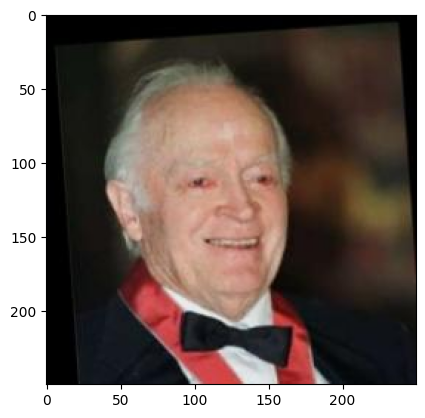

In [9]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# **The dimensions represent:**
*   Height (H): 250 pixels
*   Width (W): 250 pixels
*   Channels (C): 3 channels (RGB)

So, the sample data is an RGB image with a resolution of 250x250 pixels.

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [10]:
import torch
import torch.nn as nn

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder
        x = self.encode(x)

        # Decoder
        x = self.decode(x)
        return x

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)


# **Auto Encoder Setup**
* The encoder consists of convolutional layers with ReLU activation functions. The nn.Conv2d layers perform 2D convolution on the input. The number of input channels is 3 (for RGB images), and the number of output channels increases in each layer, reducing spatial dimensions.
* The decoder consists of transposed convolutional layers with ReLU activation functions. The nn.ConvTranspose2d layers perform 2D transposed convolution (also known as deconvolution or fractionally strided convolution). The last layer uses a sigmoid activation to ensure pixel values are in the range [0, 1].
* The forward method defines the forward pass of the autoencoder. It applies the encoder and then the decoder to the input x and returns the reconstructed output.

Additional methods encode and decode are defined to separately apply the encoder and decoder.

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [11]:
# Create an instance of the AE model
model = AE()

In [12]:
# Sample input image
sample_image, _ = next(iter(dataloader))

# Pass the image through the model
output = model(sample_image)

# Print the shape of the output of the encoder and decoder
encoded_output = model.encode(sample_image)
decoded_output = model.decode(encoded_output)

print("Shape of Encoded Output:", encoded_output.shape)
print("Shape of Decoded Output:", decoded_output.shape)


Shape of Encoded Output: torch.Size([32, 128, 16, 16])
Shape of Decoded Output: torch.Size([32, 3, 256, 256])


This code snippet takes a single batch of images, passes them through the autoencoder, and prints the shapes of the encoded and decoded outputs. This can be useful for understanding the dimensionality of the latent space and the reconstructed output produced by the autoencoder.

##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [13]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {total_params}")

Total Parameters: 194755


* Mean Squared Error (MSE) is a common loss function used to measure the difference between the input and output images. It calculates the average squared difference between corresponding pixel values.
* The optimizer can be any gradient-based optimization algorithm, such as Adam or SGD. I'm using the Adam optimizer (optim.Adam).

In [15]:
loss_function = nn.MSELoss()

In [14]:
optim = torch.optim.Adam(model.parameters(), lr=0.0001)

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [16]:
# Set the number of epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0

    for data in dataloader:
        inputs, _ = data

        # Zero the gradients
        optim.zero_grad()

        # Forward pass
        outputs = model(inputs)
        outputs = torch.nn.functional.interpolate(outputs, size=(250, 250), mode='bilinear', align_corners=False)


        # Calculate the loss
        loss = loss_function(outputs, inputs)

        # Backward pass and optimization
        loss.backward()
        optim.step()

        total_loss += loss.item()

    # Calculate average loss for the epoch
    average_loss = total_loss / len(dataloader)

    # Report the loss at the end of each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}")

print("Training finished.")


Epoch [1/10], Average Loss: 0.0500
Epoch [2/10], Average Loss: 0.0137
Epoch [3/10], Average Loss: 0.0110
Epoch [4/10], Average Loss: 0.0095
Epoch [5/10], Average Loss: 0.0081
Epoch [6/10], Average Loss: 0.0072
Epoch [7/10], Average Loss: 0.0066
Epoch [8/10], Average Loss: 0.0062
Epoch [9/10], Average Loss: 0.0059
Epoch [10/10], Average Loss: 0.0057
Training finished.


# **Troubleshooting Steps**

If the loss is not decreasing, you can try the following troubleshooting steps:

* If the learning rate is too high, the optimizer might overshoot the minimum. Try reducing the learning rate.

* If the model is too simple, it might struggle to capture the complexity of the data. Consider increasing the model's capacity by adding more layers or neurons.

* Ensure that your data is preprocessed correctly, and input normalization is appropriate. Incorrect data processing can lead to training difficulties.


##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

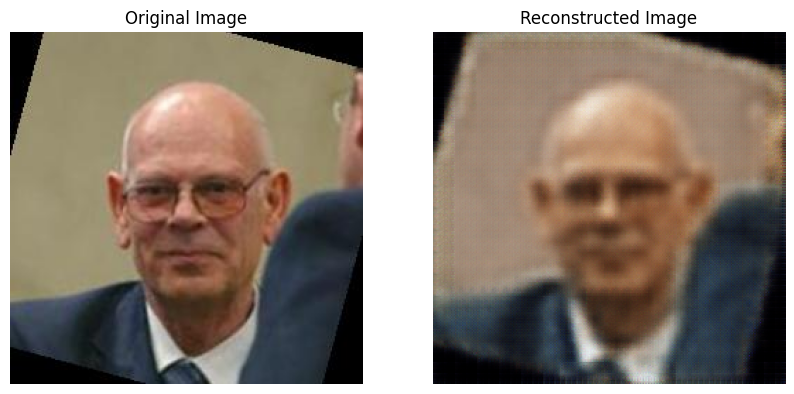

In [67]:
# Set the model in evaluation mode
model.eval()

# Get a random image from the dataset
random_data = next(iter(dataloader))
input_image, _ = random_data

# Forward pass to obtain the reconstructed image
with torch.no_grad():
    reconstructed_image = model(input_image)

# Convert the images to NumPy arrays
input_image = input_image[0].permute(1, 2, 0).numpy()
reconstructed_image = reconstructed_image[0].permute(1, 2, 0).numpy()

# Display the original and reconstructed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(input_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image)
plt.axis('off')

plt.show()

This code retrieves a random image from the dataset, passes it through the autoencoder to obtain the reconstructed image, and then visualizes both the original and reconstructed images

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

(-0.5, 255.5, 255.5, -0.5)

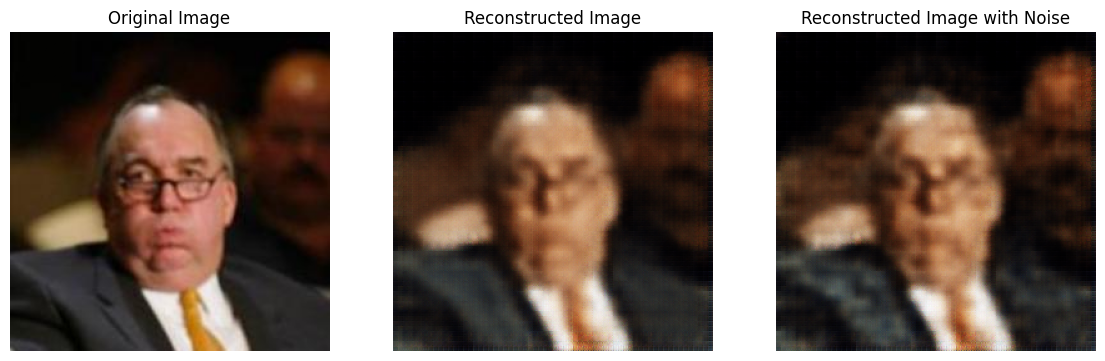

In [68]:
# Set the model in evaluation mode
model.eval()

# Get a random image from the dataset
random_data = next(iter(dataloader))
input_image, _ = random_data

# Forward pass to obtain the reconstructed image
with torch.no_grad():
    # Encode the input image
    latent_representation = model.encode(input_image)

    # Add small normally distributed noise to the intensity representation
    noise = torch.randn_like(latent_representation) * 0.8  # Adjust the noise level as needed
    latent_representation_with_noise = latent_representation + noise

    reconstructed_image_nn = model.decode(latent_representation)

    # Decode the noisy latent representation
    reconstructed_image_with_noise = model.decode(latent_representation_with_noise)

# Convert the images to NumPy arrays
input_image = input_image[0].permute(1, 2, 0).numpy()
reconstructed_image_nn = reconstructed_image_nn[0].permute(1, 2, 0).numpy()
reconstructed_image_with_noise = reconstructed_image_with_noise[0].permute(1, 2, 0).numpy()

# Display the original and reconstructed images with noise
plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(input_image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image_nn)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Reconstructed Image with Noise')
plt.imshow(reconstructed_image_with_noise)
plt.axis('off')



Adding noise helps the autoencoder learn a more robust representation of the input data.It introduces some blurriness and loss of fine details in the decoded image. It disrupts the salient features of input and makes the model sensitive to noise.